In [55]:
import torchvision

In [56]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor

training_dataset = FashionMNIST(
    root="", train=True, transform=ToTensor(), download=True
)
test_dataset = FashionMNIST(
    root="", train=False, transform=ToTensor(), download=True
)
print(training_dataset)
print(test_dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: ToTensor()


In [57]:
from torch.utils.data import DataLoader

batch_size = 64
shuffle = True
training_data_loader = DataLoader(training_dataset, batch_size, shuffle)
test_data_loader = DataLoader(test_dataset, batch_size)
print(training_data_loader)
print(training_data_loader.dataset)
print(test_data_loader)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()


torch.Size([64, 1, 28, 28])
torch.Size([64])
4 : Coat


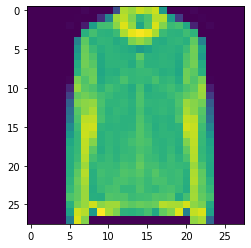

In [58]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

for X, y in training_data_loader:
  print(X.shape)
  print(y.shape)
  plt.imshow(X[0][0])
  print(y[0].item(), ':' ,labels_map[y[0].item()])
  break

In [59]:
import torch
from torch import nn

class AlexNet(nn.Module):
  def __init__(self, in_channels, class_num) -> None:
    super(AlexNet, self).__init__()
    self.extraction = nn.Sequential(
        nn.Conv2d(in_channels, 96, 11, padding="same"),
        nn.Conv2d(96, 256, 5, padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(3),
        nn.Conv2d(256, 384, 3, padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(3),
        nn.Conv2d(384, 384, 3, padding="same"),
        nn.Conv2d(384, 256, 3, padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(3),
    )
    self.flatten = nn.Flatten()
    self.classification = nn.Sequential(
        nn.Linear(256, 4096),
        nn.Linear(4096, 4096),
        nn.Linear(4096, 1000),
        nn.Linear(1000, class_num),
    )

  def forward(self, x):
    x = self.extraction(x)
    x = self.flatten(x)
    logits = self.classification(x)
    return logits

device = "cuda" if torch.cuda.is_available() else 'cpu'

model = AlexNet(1, 10).to(device)
print(model)

AlexNet(
  (extraction): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(1, 1), padding=same)
    (1): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classification): Sequential(
    (0): Linear(in_features=256, out_features=4096, bias=True)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
    (2): Linear(in_features=4096, out_features=1000, bias=True)
    (3): Linear(

In [60]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [61]:
def train(data_loader, model, loss_fn, optimizer, device):
  size = len(data_loader.dataset)
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss :>7f} [{current:>5d}/{size:>5d}]" )

epochs = 1
for epoch in range(epochs):
  print('='*10, "Epoch: ", epoch + 1, '='*10, sep='')
  train(training_data_loader, model, loss_fn, optimizer, device)


==========Epoch: 1==========
loss: 2.303731 [    0/60000]
loss: 0.963499 [ 6400/60000]
loss: 0.753596 [12800/60000]
loss: 0.775425 [19200/60000]
loss: 0.443460 [25600/60000]
loss: 0.481438 [32000/60000]
loss: 0.430679 [38400/60000]
loss: 0.863562 [44800/60000]
loss: 0.551911 [51200/60000]
loss: 0.637419 [57600/60000]


In [62]:
def test(data_loader, model, loss_fn, device):
  loss_sum = 0
  correct_sum = 0
  model.eval()
  with torch.no_grad():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      preds = model(X)
      loss = loss_fn(preds, y)
      loss_sum += loss.item()
      correct_sum += (preds.argmax(-1) == y).type(torch.float).sum().item()
  print(f"Total Loss {loss_sum / len(data_loader):>5f}")
  print(f"Total Accuracy {(correct_sum / len(data_loader.dataset)) * 100 :>.1f}%")

test(test_data_loader, model, loss_fn, device)

Total Loss 0.563055
Total Accuracy 79.9%
